# MFML - Final Project

### Feature importance via wavelet decomposition of RF - Reproduce the feature importance results of [1]

1. Provide summary of the wavelet-based method with emphasis on the use of the validation set to
determine a threshold for wavelet norms.
1. Test on regression & classification problems (multi-class problems).
1. Compare extensively with standard methods as in [1]. 

#### We will use the following data sets (suggestions):

   - Classification
       - Red Wine Quality as in [1]
       - [Human Activity Recognition Using Smartphones Data Set](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones)
           - Nice dataset + I have some experience with it [link](https://github.com/AvivNavon/HAR/blob/master/HAR_Notebook.ipynb), but there are 561 features, so maybe it will be hard for the wavelet decomposition code to run.
       - [Seeds](https://archive.ics.uci.edu/ml/datasets/seeds)
       - [Vertebral Column](https://archive.ics.uci.edu/ml/datasets/Vertebral+Column)
       - [Titanic](https://www.kaggle.com/c/titanic/data) 
           - small data set so should be quick, but mechaamem and not multi-class.
       - [Larger classification datasets (larger than 1000 obs.)](https://archive.ics.uci.edu/ml/datasets.html?format=&task=cla&att=&area=&numAtt=less10&numIns=greater1000&type=&sort=nameUp&view=list)
   - Regression
       - [Abalone Data Set](https://archive.ics.uci.edu/ml/datasets/Abalone)
       - [Some more boring stuff](https://archive.ics.uci.edu/ml/datasets.html?format=&task=reg&att=&area=&numAtt=less10&numIns=100to1000&type=&sort=nameUp&view=list)
       
#### Algs:

   - RF
   - LightGBM
   - XGBoost
   - ...
   
#### Some other things to look at

   - [Shap](https://github.com/slundberg/shap)
   
   
### Navigation

1. [Seeds](Seeds) 
1. []()

#### References
    
[[1]](http://www.jmlr.org/papers/volume17/15-203/15-203.pdf)  O. Elisha and S. Dekel, Wavelet decompositions of Random Forests - smoothness analysis, sparse
approximation and applications, JMLR 17 (2016). 

In [2]:
# Ignore warnings# Ignor 
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Vis.
from plotnine import *
from matplotlib.colors import rgb2hex
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
%matplotlib inline

## Seeds

[Top](#MFML---Final-Project)

In [5]:
seeds_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt", 
            error_bad_lines = False,
            header = None,
            sep = "\t")
seeds_data.columns = ['a', 'b', 'c', 'd', 'e', 'f' ,'g', 'h']
print(seeds_data.shape)
seeds_data.head()

(199, 8)


b'Skipping line 8: expected 8 fields, saw 10\nSkipping line 36: expected 8 fields, saw 10\nSkipping line 61: expected 8 fields, saw 9\nSkipping line 69: expected 8 fields, saw 9\nSkipping line 107: expected 8 fields, saw 9\nSkipping line 136: expected 8 fields, saw 9\nSkipping line 170: expected 8 fields, saw 9\nSkipping line 171: expected 8 fields, saw 9\nSkipping line 173: expected 8 fields, saw 9\nSkipping line 202: expected 8 fields, saw 9\nSkipping line 204: expected 8 fields, saw 9\n'


,a,b,c,d,e,f,g,h
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


## Human Activity Recognition Using Smartphones Data


### [Link to very nice kernel](https://www.kaggle.com/morrisb/what-does-your-smartphone-know-about-you)

In [14]:
har_test = pd.read_csv("data/har-test.csv")
print(har_test.shape)
har_test.head()

(2947, 563)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2,STANDING
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2,STANDING
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2,STANDING
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2,STANDING
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2,STANDING


In [15]:
har_train = pd.read_csv("data/har-train.csv")
print(har_train.shape)
har_train.head()

(7352, 563)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


### PCA + TSNE

In [23]:
# remove subject, activity
subject, activity = har_train.subject, har_train.Activity
har_train.drop(columns=['subject', 'Activity'], inplace = True)

In [36]:
tsna_train = har_train.copy()
pca = PCA(n_components=0.9, random_state=123)
scl = StandardScaler()
tsna_train = scl.fit_transform(tsna_train)
tsna_train = pca.fit_transform(har_train)
tsne = TSNE(random_state=123)
tsna_train = tsne.fit_transform(tsna_train)

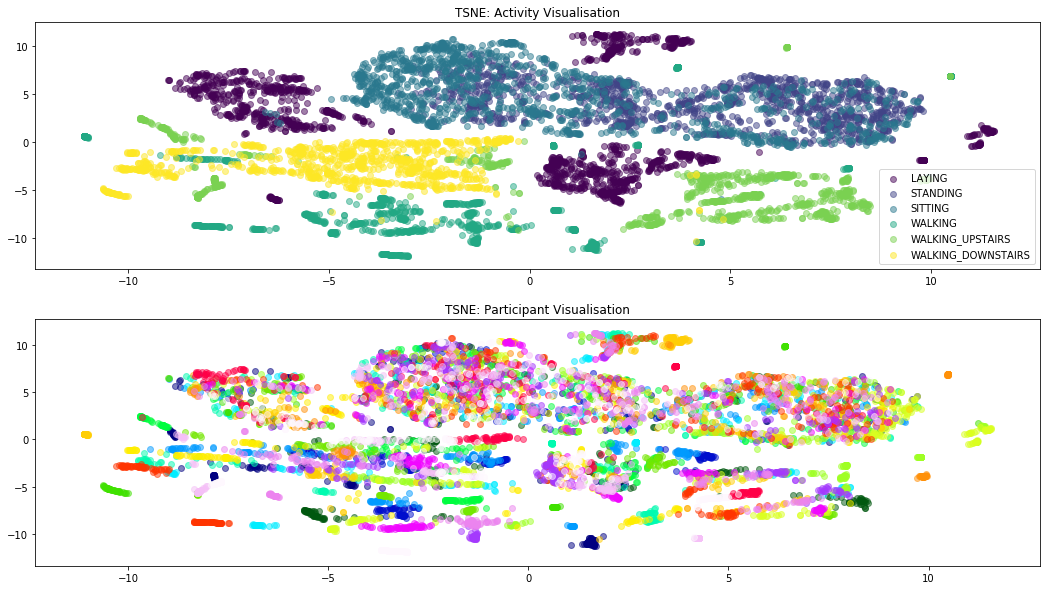

In [39]:
# Create subplots
fig, axarr = plt.subplots(2, 1, figsize=(18,10))

### Plot Activities
# Get colors
n = activity.unique().shape[0]
colormap = get_cmap('viridis')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

label_counts = activity.value_counts()

# Plot each activity
for i, group in enumerate(label_counts.index):
    # Mask to separate sets
    mask = (activity==group).values
    axarr[0].scatter(x=tsna_train[mask][:,0], y=tsna_train[mask][:,1], c=colors[i], alpha=0.5, label=group)
axarr[0].set_title('TSNE: Activity Visualisation')
axarr[0].legend()


### Plot Subjects
# Get colors
n = subject.unique().shape[0]
colormap = get_cmap('gist_ncar')
colors = [rgb2hex(colormap(col)) for col in np.arange(0, 1.01, 1/(n-1))]

# Plot each participant
for i, group in enumerate(subject.unique()):
    # Mask to separate sets
    mask = (subject==group).values
    axarr[1].scatter(x=tsna_train[mask][:,0], y=tsna_train[mask][:,1], c=colors[i], alpha=0.5, label=group)

axarr[1].set_title('TSNE: Participant Visualisation')
plt.show()